# Generating Specie Signature
* Weekly data, normalized and not

# Imports

In [1]:
import os
import random
import calendar
import datetime
import warnings
import logging
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import calendar
warnings.filterwarnings("ignore")
tqdm.pandas()

## Config

In [2]:
# Config
PROJECT_ID = "arpae-prod-ml"

# Dataset path
dataset_path = "data/"

## Methods

In [3]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

___

# 1. Load Dataset

### Load clustering results

In [4]:
### Load clustering data
# clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")
clusters = pd.read_csv("data/clusters/clustering_intervals.csv")

print(clusters.shape)
display(clusters.sample(3))

# plt.figure(figsize=(8,2))
# plt.title("Number of specie/station per cluster")
# sns.countplot(x=clusters["cluster"]);

(363, 3)


,station_id,pol_var_id,cluster
21,1,B48030,1
209,8,B48016,1
63,2,B48041,0


### Load dataset

In [5]:
window_size = 7
dataset_path, dataset_type = f"data/dataset_{window_size}D_normalized.feather", "normalized"

# Load dataset
df_dataset = pd.read_feather(dataset_path)
df_dataset.drop_duplicates(inplace=True)

# Convert dates, sort and set index
df_dataset.drop("date_diff", axis=1, inplace=True)
df_dataset.date = pd.to_datetime(df_dataset.date)
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_dataset.set_index("date", inplace=True)

df_dataset["day"] = df_dataset.index.day
df_dataset["month"] = df_dataset.index.month
df_dataset["year"] = df_dataset.index.year

### Join Cluster label

In [6]:
# Select species/stations from cluster result
df_dataset = pd.merge(df_dataset.reset_index(), clusters, on=["station_id", "pol_var_id"], how="inner")
df_dataset.station_id = df_dataset.station_id.astype(int)
df_dataset.dropna(inplace=True)
df_dataset.set_index("date", inplace=True)

In [7]:
### Dataset preview
print(df_dataset.shape)
df_dataset.head(5)

(1135172, 102)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,day,month,year,cluster
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05,1,B48001,0.0,0.010309,0.007163,0.010346,0.005140,0.555556,0.707631,0.648377,...,0,0,0,0,0,training,5,9,2006,3
2006-09-06,1,B48001,0.0,0.010309,0.001791,0.004397,0.001285,0.555556,0.707631,0.644707,...,0,0,0,0,0,training,6,9,2006,3
2006-09-07,1,B48001,0.0,0.000000,0.000000,0.000000,0.000000,0.555556,0.684836,0.625042,...,0,0,0,0,0,training,7,9,2006,3
2006-09-08,1,B48001,0.0,0.017182,0.015519,0.011157,0.011137,0.555556,0.677899,0.585648,...,0,0,0,0,0,training,8,9,2006,3
2006-09-09,1,B48001,0.0,0.044674,0.031038,0.037994,0.022275,0.555556,0.679881,0.582157,...,0,0,0,0,0,training,9,9,2006,3


___

# 2. What is a signature

In [8]:
def get_mean(signals):
    # Compute the mean signal
    mean_signal = np.mean(signals, axis=0)

    # Normalize signature between 0 and 1
    min_val = mean_signal.min()
    max_val = mean_signal.max()
    norm_sig = (mean_signal - min_val) / (max_val - min_val)

    return "mean", norm_sig

def get_std_over_mean(signals):
    # Compute the mean signal
    mean_signal = np.std(signals, axis=0) / np.mean(signals, axis=0)

    # Normalize signature between 0 and 1
    min_val = mean_signal.min()
    max_val = mean_signal.max()
    norm_sig = (mean_signal - min_val) / (max_val - min_val)

    return "std/mean", norm_sig

def get_eigvn_signature(signals):
    # Compute the mean signal
    mean_signal = np.mean(signals, axis=0)

    # Subtract the mean signal from each signal in the matrix
    centered_data = signals - mean_signal

    # Compute the covariance matrix of the centered data
    covariance_matrix = np.cov(centered_data.T)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort the eigenvectors in descending order of their corresponding eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Take the eigenvector with the largest eigenvalue and use it as your signature signal
    signature_signal = sorted_eigenvectors[:, 1]

    # Normalize
    signature_signal = (signature_signal + 1) / 2

    return "eigenv", signature_signal

In [9]:
sample = clusters.sample(1).iloc[0]
sample = df_dataset[(df_dataset.station_id == sample.station_id) & (df_dataset.pol_var_id == sample.pol_var_id)]
sample = sample.copy()
sample.head(3)

,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,day,month,year,cluster
date,,,,,,,,,,,,,,,,,,,,,
2006-10-06,7,B48005,0.0,0.010309,0.007323,0.011468,0.005140,0.388889,0.574827,0.400166,...,0,0,0,0,0,training,6,10,2006,8
2006-10-07,7,B48005,0.0,0.010309,0.013888,0.017448,0.009852,0.388889,0.574827,0.352283,...,0,0,0,0,0,training,7,10,2006,8
2006-10-08,7,B48005,0.0,0.018900,0.015082,0.021924,0.010709,0.388889,0.574827,0.357494,...,0,0,0,0,0,training,8,10,2006,8


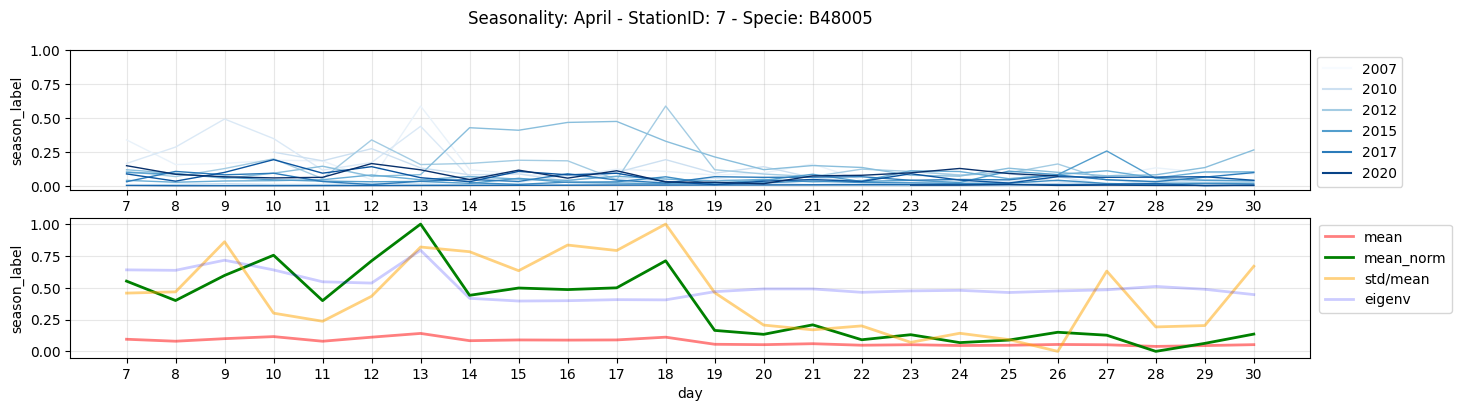

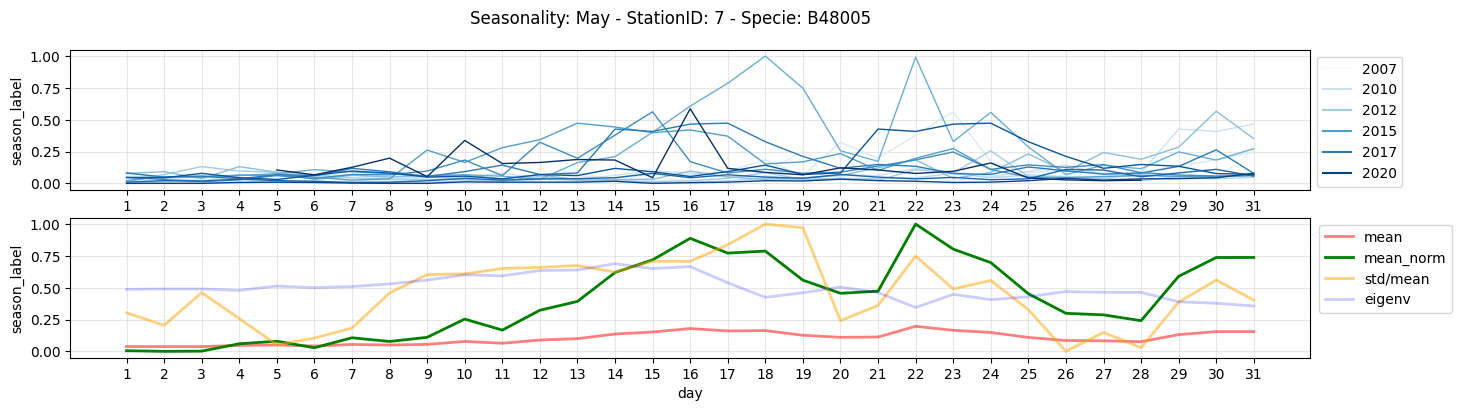

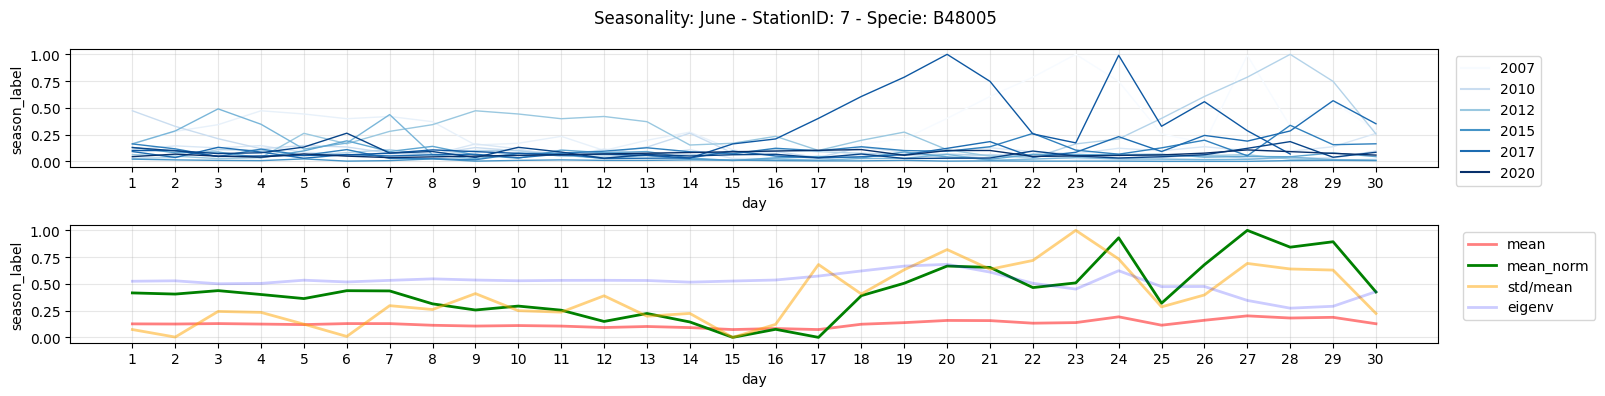

In [10]:
### Seasonality signature
for ith, (month, group) in enumerate(sample.groupby("month")):
    
    fig, axs = plt.subplots(2, figsize=(16,4))
    fig.suptitle(f"Seasonality: {calendar.month_name[month]} - StationID: {group.station_id.iloc[0]} - Specie: {group.pol_var_id.iloc[0]}")
    
    ### Plot seasonalities
    sns.lineplot(data=group, x="day", y="season_label", hue="year", lw=1, palette="Blues", ax=axs[0])
    axs[0].legend(loc="upper right", bbox_to_anchor=(1.08, 1))
    axs[0].set_xticks(np.arange(group.day.min(), group.day.max()+1))
    axs[0].set_yticks(np.arange(0, 1.1, .25))
    axs[0].grid(alpha=.3)
    
    ### Get specie year seasonalities
    month_seasons, month_seasons = zip(*list(group.groupby("day")["season_label"]))
    month_seasons = [m.values for m in month_seasons]
    month_seasons = pd.DataFrame(month_seasons).T
    month_seasons.fillna(0, inplace=True)

    # Mean
    seasonal_mean = group.groupby("day")["season_label"].mean()
    sns.lineplot(seasonal_mean, lw=2, c="red", label="mean", alpha=.5, ax=axs[1])

    # Mean norm
    #seasonal_mean_norm = group.groupby("day")["season_label"].mean() / seasonal_mean.max()
    seasonal_mean_norm = (seasonal_mean - seasonal_mean.min()) / (seasonal_mean.max() - seasonal_mean.min())
    sns.lineplot(seasonal_mean_norm, lw=2, c="green", label="mean_norm", ax=axs[1])

    # STD/Mean
    feat_name, signature = get_std_over_mean(month_seasons)
    sns.lineplot(x=seasonal_mean.index, y=signature, lw=2, c="orange", alpha=.5, label=feat_name, ax=axs[1])

    # Eigenvector
    feat_name, signature = get_eigvn_signature(month_seasons)
    sns.lineplot(x=seasonal_mean.index, y=signature, lw=2, c="blue", alpha=.2, label=feat_name, ax=axs[1])

    axs[1].legend(loc="upper right", bbox_to_anchor=(1.12, 1))
    axs[1].set_xticks(np.arange(seasonal_mean.index.min(), seasonal_mean.index.max()+1))
    axs[1].set_yticks(np.arange(0, 1.1, .25))
    axs[1].grid(alpha=.3)
    if ith == 2: break

plt.tight_layout()
plt.show()

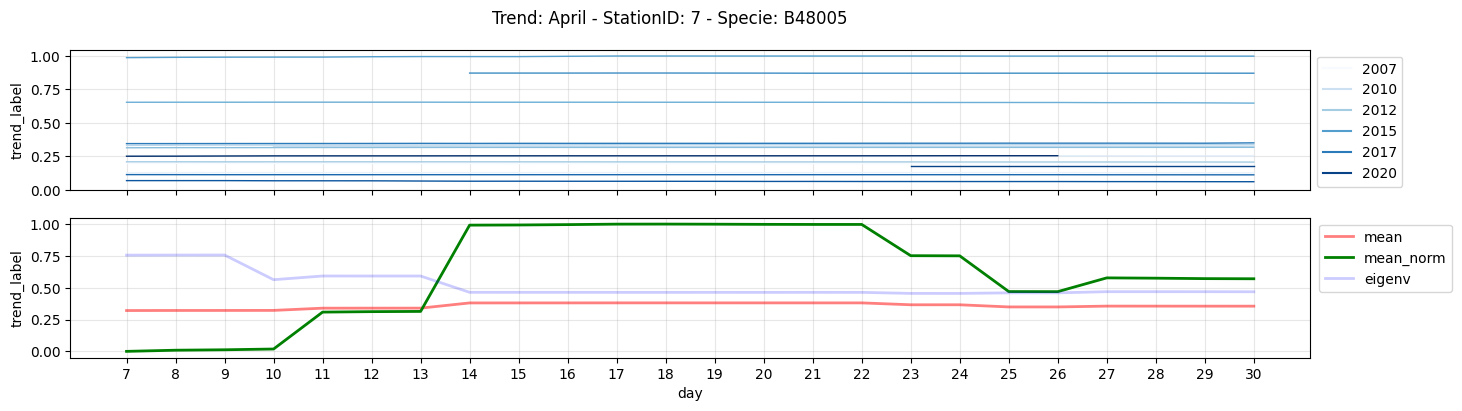

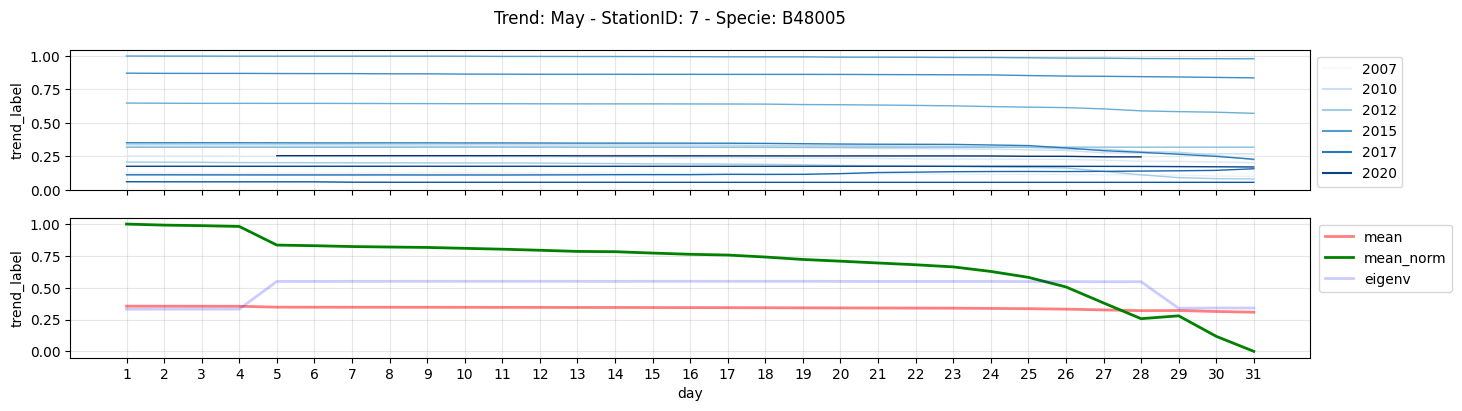

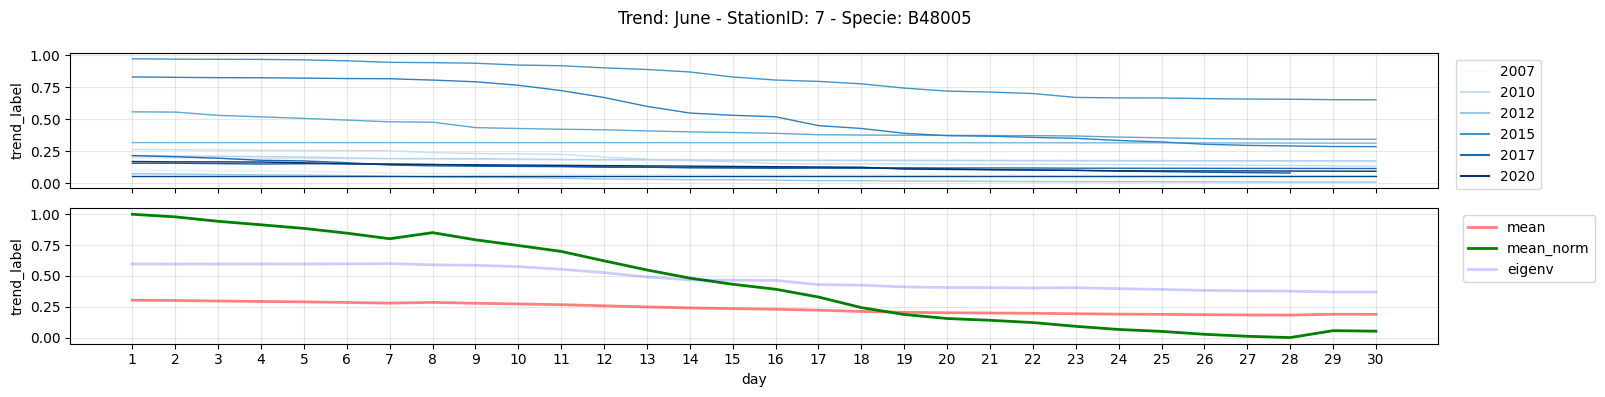

In [11]:
### Seasonality signature
for ith, (month, group) in enumerate(sample.groupby("month")):

    fig, axs = plt.subplots(2, figsize=(16,4), sharex=True)
    fig.suptitle(f"Trend: {calendar.month_name[month]} - StationID: {group.station_id.iloc[0]} - Specie: {group.pol_var_id.iloc[0]}")

    ### Plot seasonalities
    sns.lineplot(data=group, x="day", y="trend_label", hue="year", lw=1, palette="Blues", ax=axs[0])
    axs[0].legend(loc="upper right", bbox_to_anchor=(1.08, 1))
    axs[0].set_xticks(np.arange(group.day.min(), group.day.max()+1))
    axs[0].set_yticks(np.arange(0, 1.1, .25))
    axs[0].grid(alpha=.3)

    ### Get specie year seasonalities
    month_seasons, month_seasons = zip(*list(group.groupby("day")["trend_label"]))
    month_seasons = [m.values for m in month_seasons]
    month_seasons = pd.DataFrame(month_seasons).T
    month_seasons.fillna(0, inplace=True)

    # Mean
    seasonal_mean = group.groupby("day")["trend_label"].mean()
    sns.lineplot(seasonal_mean, lw=2, c="red", label="mean", alpha=.5, ax=axs[1])

    # Mean norm
    seasonal_mean_norm = (seasonal_mean - seasonal_mean.min()) / (seasonal_mean.max() - seasonal_mean.min())
    sns.lineplot(seasonal_mean_norm, lw=2, c="green", label="mean_norm", ax=axs[1])

    # Eigenvector
    feat_name, signature = get_eigvn_signature(month_seasons)
    sns.lineplot(x=seasonal_mean.index, y=signature, lw=2, c="blue", alpha=.2, label=feat_name, ax=axs[1])

    axs[1].legend(loc="upper right", bbox_to_anchor=(1.12, 1))
    axs[1].set_xticks(np.arange(seasonal_mean.index.min(), seasonal_mean.index.max()+1))
    axs[1].set_yticks(np.arange(0, 1.1, .25))
    axs[1].grid(alpha=.3)
    if ith == 2: break

plt.tight_layout()
plt.show()

___

# 3. Generating Signatures
### Metrics chosen
* Seasonality: normalized mean
* Trend: mean

In [12]:
def get_feature_pivot(specie, feature):
    day_month = specie.index.day.astype(str) + "_" + specie.index.month.astype(str)
    
    group = specie.groupby(day_month)[feature]
    idxs, seasons = zip(*list(group))

    seasons = [m.values for m in seasons]
    seasons = pd.DataFrame(seasons).T
    seasons.columns = idxs
    seasons.fillna(0, inplace=True)
    return seasons

def join_date_index(season_signature, trend_signature):
    idx = list(map(lambda s: s.split("_"), season_signature.index.values))
    season_signature = np.hstack((idx, season_signature.values.reshape((-1, 1))))
    season_signature = pd.DataFrame(season_signature, columns=["day", "month", "season_signature"])
    season_signature.day = season_signature.day.astype(int)
    season_signature.month = season_signature.month.astype(int)
    season_signature.season_signature = season_signature.season_signature.astype(float)

    idx = list(map(lambda s: s.split("_"), trend_signature.index.values))
    trend_signature = np.hstack((idx, trend_signature.values.reshape((-1, 1))))
    trend_signature = pd.DataFrame(trend_signature, columns=["day", "month", "trend_signature"])
    trend_signature.day = trend_signature.day.astype(int)
    trend_signature.month = trend_signature.month.astype(int)
    trend_signature.trend_signature = trend_signature.trend_signature.astype(float)
    
    return season_signature, trend_signature

def get_feature_signature(specie_group):
    # Generate season signature
    seasons = get_feature_pivot(specie_group, feature="season_label")
    season_signature = seasons.mean(axis=0)
    # season_signature = (season_signature - season_signature.min()) / (season_signature.max() - season_signature.min())

    # Generate trend signature
    trends = get_feature_pivot(specie_group, feature="trend_label")
    trend_signature = trends.mean(axis=0)
    
    # Join date index
    season_signature, trend_signature = join_date_index(season_signature, trend_signature)
    
    # Merge trend/season signatures
    signatures = pd.merge(season_signature, trend_signature, on=["day", "month"])
    
    return signatures

In [13]:
### Evaluate signatures
species_signatures = df_dataset.groupby(["station_id", "pol_var_id"]).progress_apply(get_feature_signature)

  0%|          | 0/363 [00:00<?, ?it/s]

In [14]:
### Join dataset
df_dataset.reset_index(inplace=True)
df_dataset = pd.merge(df_dataset, species_signatures, how="left", on=["station_id", "pol_var_id", "day", "month"])
df_dataset.set_index("date", inplace=True)

print(df_dataset.shape)
df_dataset.head(3)

(1135172, 104)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,day,month,year,cluster,season_signature,trend_signature
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05,1,B48001,0.0,0.010309,0.007163,0.010346,0.005140,0.555556,0.707631,0.648377,...,0,0,0,training,5,9,2006,3,0.152378,0.591799
2006-09-06,1,B48001,0.0,0.010309,0.001791,0.004397,0.001285,0.555556,0.707631,0.644707,...,0,0,0,training,6,9,2006,3,0.096312,0.594864
2006-09-07,1,B48001,0.0,0.000000,0.000000,0.000000,0.000000,0.555556,0.684836,0.625042,...,0,0,0,training,7,9,2006,3,0.125102,0.597809


In [15]:
# Groupby 'station_id' and 'pol_var_id' columns
df_normalized = df_dataset.copy()
df_grouped = df_normalized.groupby(['station_id', 'pol_var_id'])

In [16]:
### Normalize feature signatures
feature_signatures = ["season_signature", "trend_signature"]
scaler = MinMaxScaler()
df_normalized[feature_signatures] = df_grouped[feature_signatures].progress_apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns)).values

  0%|          | 0/363 [00:00<?, ?it/s]

___

# 4. Visualize results

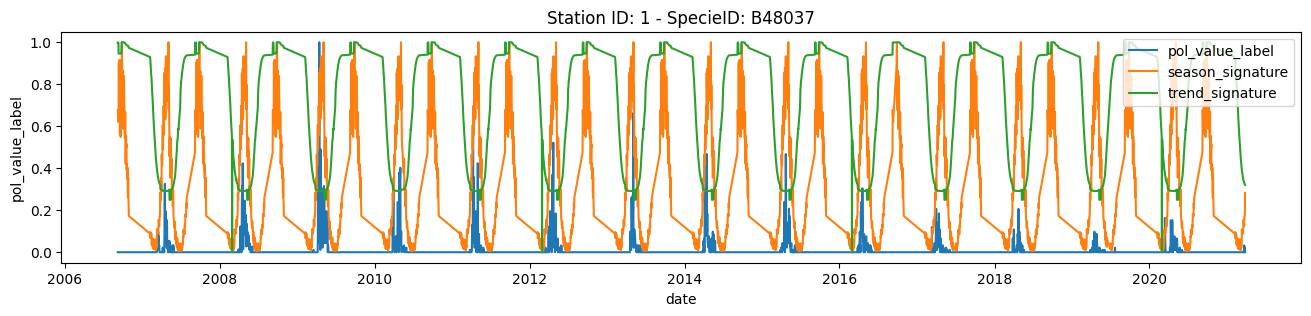

In [17]:
sample = clusters.sample(1).iloc[0]
sample = df_normalized[(df_normalized.station_id == sample.station_id) & (df_normalized.pol_var_id == sample.pol_var_id)]

plt.figure(figsize=(16,3))
plt.title(f"Station ID: {sample.station_id.iloc[0]} - SpecieID: {sample.pol_var_id.iloc[0]}")
sns.lineplot(data=sample, x=sample.index, y="pol_value_label", label="pol_value_label")
sns.lineplot(data=sample, x=sample.index, y="season_signature", label="season_signature")
sns.lineplot(data=sample, x=sample.index, y="trend_signature", label="trend_signature")
plt.legend(loc="upper right")
plt.show()

___

# 5. Store dataset

In [18]:
output_path = "data/dataset_7D_normalized_tsd-signature.feather"

In [19]:
df_dataset.reset_index(inplace=True)
df_dataset.to_feather(output_path)